In [ ]:
# in this notebook, we show how to query Wikidata with SPARQL, getting back a list of entities that we will use to
# create a News Signals dataset

# (1) get a list of US politicians from Wikidata
# (2) query for current news volumes and rank by anomalies
# (3) understand the main stories for current trending politicians

In [1]:
import requests
import pandas as pd
import requests
import datetime
import tqdm 

from news_signals import signals
from collections import OrderedDict

In [2]:
# SPARQL Query for living US politicians
sparql_query = """
SELECT DISTINCT ?politician ?label ?aliases ?desc
WHERE {
  ?politician wdt:P31 wd:Q5; # Human
              wdt:P106 wd:Q82955; # Occupation: Politician
              wdt:P27 wd:Q30; # Country of citizenship: United States
              wdt:P39 ?position. # Position held

  # National-level positions
  VALUES ?position {
    wd:Q11696 # President of the United States
    wd:Q11699 # Vice President of the United States
    wd:Q13218630 # Member of the United States House of Representatives
    wd:Q4416090 # United States Senator
  }

  FILTER NOT EXISTS { ?politician wdt:P570 ?deathDate. } # Filter out politicians with a death date

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en".
      ?politician rdfs:label ?label.
      ?politician skos:altLabel ?aliases.
      ?politician schema:description ?desc.
  }
}
ORDER BY ?label

"""

In [3]:
RESULT_POSTPROCESSORS = {
    'politician': lambda uri: uri.replace("http://www.wikidata.org/entity/",""),
    'aliases': lambda aliases: [a.strip() for a in aliases.split(', ')]
}

UNIQUE_FIELDS = ['politician']


def sparql2df(sparql_query, endpoint="https://query.wikidata.org/sparql?format=json"):
    res = requests.get(
        endpoint,
        params={"query": sparql_query}
    ).json()
    
    # parse results
    rows = []
    for r in res['results']['bindings']:
        row = {}
        for k, v in r.items():
            postprocess = RESULT_POSTPROCESSORS.get(k, lambda x: x)
            v = postprocess(v['value'])
            row[k] = v
            rows.append(row)
    
    return pd.DataFrame.from_records(rows).drop_duplicates(UNIQUE_FIELDS).reset_index()

In [4]:
# Ok let's get a dataframe of entities from the Wikidata Query Service
entity_df = sparql2df(sparql_query)
entity_df

,index,politician,label,aliases,desc
0,0,Q302659,Aaron Schock,"[Aaron Jon Schock, Aaron Shock]",American politician
1,4,Q24435337,Abby Finkenauer,[Abby Lea Finkenauer],American politician
2,8,Q55603085,Abigail Spanberger,[Abigail Anne Spanberger],American politician
3,12,Q349955,Adam Kinzinger,[Adam Daniel Kinzinger],American politician
4,16,Q350663,Adam Putnam,[Adam Hughes Putnam],American politician
...,...,...,...,...,...
1593,6111,Q16225780,Yvette Herrell,[Stella Yvette Herrell],"American politician, businesswoman, and real e..."
1594,6115,Q538206,Yvonne Brathwaite Burke,NaN,American politician
1595,6118,Q139389,Zach Wamp,[Zachary Paul Wamp],American politician
1596,6122,Q139887,Zack Space,NaN,American politician


In [5]:
# Aliases for Barack Obama
print([a for a in entity_df[entity_df['label'] == 'Barack Obama']['aliases']])

[['Obama', 'BHO', 'President Barack Obama', 'Barack', 'Barack H. Obama', 'Barack Hussein Obama', 'Barack Hussein Obama II', 'Barack Obama II', 'Barak Obama', 'Barry Obama', 'President Obama', 'Honorable Barack Obama']]


In [6]:
def entity2signal(entity):
    surface_forms = set([entity['label']])
    if type(entity['aliases']) is list:
        surface_forms.update(entity['aliases'])
    surface_forms = list(surface_forms)
    
    return signals.AylienSignal(
        name=entity['label'],
        params={
            'entity_surface_forms_text': surface_forms,
            'min_prominence_score': 0.7
        }
    )


In [7]:
label2signal = OrderedDict()

for record in entity_df.to_dict(orient='records'):
    label2signal[record['label']] = entity2signal(record)

In [8]:
# from this cell you need to have Aylien NewsAPI credentials set up

start = '2023-02-01'
end = '2023-04-03'

anomaly_detection_start = '2023-03-24'

# which politicians are currently anomalous with respect to news volume?
# init anomaly signals
# querying for ~1600 signals will take around 15 minutes
cutoff = 10
for label, signal in tqdm.tqdm(list(label2signal.items())[:cutoff]):
    label2signal[label] = signal(start, end).anomaly_signal(anomaly_detection_start, end)

100%|███████████████████████████████████████████| 10/10 [00:19<00:00,  1.90s/it]


In [9]:
list(label2signal.keys())[:cutoff]

['Aaron Schock',
 'Abby Finkenauer',
 'Abigail Spanberger',
 'Adam Kinzinger',
 'Adam Putnam',
 'Adam Schiff',
 'Adam Smith',
 'Adrian Smith',
 'Adriano Espaillat',
 "Al D'Amato"]

<Axes: xlabel='date'>

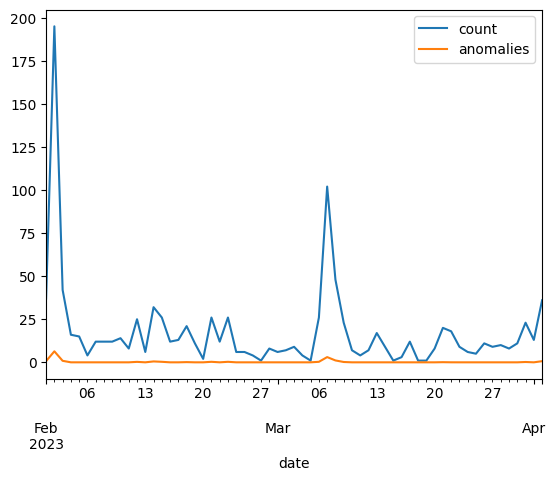

In [11]:
label2signal['Adam Schiff'].plot()

In [12]:
def investigate_signal(signal):
    if signal[signal.ts_column].sum() == 0:
        print('Signal timeseries is always zero, nothing to investigate')
        return
    most_anomalous_day = signal['anomalies'].idxmax()
    _ = signal.sample_stories_in_window(
        start=most_anomalous_day,
        end=most_anomalous_day + datetime.timedelta(days=1)
    )
    daily_stories = signal.feeds_df['stories']
    title_dedup = set()
    for stories in daily_stories:
        if type(stories) is list:
            for s in stories:
                if s['title'] not in title_dedup:
                    print(s['title'])
                    # try to find a place where the entity was mentioned
                    sf_idx = s['body'].find(signal.name)
                    if sf_idx > -1:
                        sf_end_idx = len(signal.name) + sf_idx
                        print(f'{s["body"][sf_idx-50:sf_idx]} __{s["body"][sf_idx:sf_end_idx]}__ {s["body"][sf_end_idx:sf_end_idx+50]}')
                    title_dedup.update(s['title'])


In [13]:
for politician_name in list(label2signal.keys())[:cutoff]:
    print()
    print(f'Investigating {politician_name}')
    print(entity_df[entity_df['label'] == politician_name])
    investigate_signal(label2signal[politician_name])


Investigating Aaron Schock
   index politician         label                          aliases  \
0      0    Q302659  Aaron Schock  [Aaron Jon Schock, Aaron Shock]   

                  desc  
0  American politician  
Signal timeseries is always zero, nothing to investigate

Investigating Abby Finkenauer
   index politician            label                aliases  \
1      4  Q24435337  Abby Finkenauer  [Abby Lea Finkenauer]   

                  desc  
1  American politician  


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


US midterm elections: A look at the House's 'firsts'
0 PM | Last Updated: 07th November 2018 07:11 PM
  __Abby Finkenauer__  (First congresswoman from Iowa): Abby Finkenauer 

Investigating Abigail Spanberger
   index politician               label                    aliases  \
2      8  Q55603085  Abigail Spanberger  [Abigail Anne Spanberger]   

                  desc  
2  American politician  


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]


After serving in CIA, lawmaker now has role overseeing it
 __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
After serving in CIA, lawmaker now has role overseeing it
 __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
After serving in CIA, lawmaker now has role overseeing it
 __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
After serving in CIA, lawmaker now has role overseeing it
 an officer running spies for the CIA
FILE - Rep.  __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
After serving in CIA, lawmaker now has role overseeing it
 an officer running spies for the CIA
FILE - Rep.  __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
After serving in CIA, lawmaker now has role overseeing it
By NOMAAN MERCHANT - Associated Press
FILE - Rep.  __Abigail Spanberger__ , D-Va., arrives as Democrats hold elections for t
Amid Ongoing Staffing Shortages, Spanberger Relaunch

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Former US Rep. Adam Kinzinger to release book in October
 __Adam Kinzinger__ , R-Ill., speaks as the House select committee inv
Former US Rep. Adam Kinzinger to release book in October
al

NEW YORK -- NEW YORK (AP) —

Former U.S. Rep.  __Adam Kinzinger__ , the Illinois Republican who broke with his party
Former US Rep. Adam Kinzinger to release book in October
W YORK (AP) —

                  Former U.S. Rep.  __Adam Kinzinger__ , the Illinois Republican who broke with his party
Former US Rep. Adam Kinzinger to release book in October
again later {{ /verifyErrors }}

Former U.S. Rep.  __Adam Kinzinger__ , the Illinois Republican who broke with his party
Former US Rep. Adam Kinzinger to release book in October
 __Adam Kinzinger__ , R-Ill., speaks as the House select committee inv
Former US Rep. Adam Kinzinger to release book in October
 __Adam Kinzinger__ , R-Ill., speaks as the House select committee inv
Former US Rep. Adam Kinzinger to release book in October
 __Adam Kinzinger__ , the

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


PEOPLE Pours Out Tub of Goo for Young Socialist Congressman Maxwell Frost
ell Frost (D-Fla.), elected at age 25.

When Rep.  __Adam Putnam__  (R-Fla.) was elected at age 26 in 2000, no libera

Investigating Adam Schiff
   index politician        label                                aliases  \
5     20    Q350843  Adam Schiff  [Adam B. Schiff, Adam Bennett Schiff]   

                  desc  
5  American politician  


100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.42s/it]


'They increase the level of hate and violence': Adam Schiff blasts the GOP's 'demonization' of immigrants
 __Adam Schiff__  (D-California) on Wednesday refuted Republican vi
Opinion | New Hope for Russiagate Truths
 __Adam Schiff__ 's speculations are correct, the FBI was bamboozle
Adam Schiff to run for Feinstein’s Senate seat
 __Adam Schiff__ , who chaired the House Intelligence Committee dur
Nancy Pelosi endorses Adam Schiff in California Senate race
cy Pelosi, D-San Francisco, speaks alongside Rep.  __Adam Schiff__ , D-Burbank, at a news conference at the U.S. Capi
Pelosi backs Schiff for California Senate seat if Feinstein doesn’t run
 be supporting House Intelligence Committee Chair  __Adam Schiff__ , who knows well the nexus between a strong Democr
Pelosi endorses Schiff in California Senate race if Feinstein retires
 Nancy Pelosi has endorsed fellow Democratic Rep.  __Adam Schiff__  for the U.S. Senate if Sen. Dianne Feinstein of C
Pelosi backing Schiff if Feinstein retires
anc

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it]


Adam Smith Institute Nab Ex-Treasury SpAd as New Executive Director
 __Adam Smith__  Institute Nab Ex-Treasury SpAd as New Director



USA: Rep. Smith Statement on House Republican Resolution Denouncing Socialism
ted States House of Representatives – Congressman  __Adam Smith__  (9th District of Washington)

WASHINGTON, D.C. – 
USA: Rep. Smith Statement on the Select Committee on the Strategic Competition Between the United States and the Chinese Communist Party
ted States House of Representatives – Congressman  __Adam Smith__  (9th District of Washington)

WASHINGTON, D.C. – 
USA: Rep. Smith Statement on the Terrorist Attack in Jerusalem
ted States House of Representatives – Congressman  __Adam Smith__  (9th District of Washington)

WASHINGTON, D.C. – 
USA: U.S. Treasury Under Secretary Brian E. Nelson Visits 9th District for Roundtable with Local Money Service Businesses Hosted by Congressman Smith
ted States House of Representatives – Congressman  __Adam Smith__  (9th District of Wa

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.21it/s]


Smith Announces Caseworker in your Community Events.
 __Adrian Smith__  has issued the following news release:


Constitu
Rep. Adrian Smith (R-NE) News Release
D.C. - Constituents of Third District Congressman  __Adrian Smith__  (R-NE) are invited to meet with a congressional c
Luxhabitat Sotheby's spearheads sales of SO/ Uptown Dubai residences
 __Adrian Smith__  and Gordon Gill Architecture, SO/ Uptown Dubai is
Congressman Johnson and other midwest lawmakers launch “Biofules Caucus”
iofuels Caucus Leadership Dusty Johnson (R-S.D.),  __Adrian Smith__  (R-NE), Angie Craig (D-MN), and Mark Pocan (D-WI)
Celebrity birthdays: Feb. 27
pall.
 Adam Baldwin
  Actor Adam Baldwin is 61.
   __Adrian Smith__ 
  Rock musician Adrian Smith (Iron Maiden) is 66.
Celebrity birthdays: Feb. 27      Feb 27, 2023    7 min ago
 __Adrian Smith__   Barbara Babcock  Brandon Beemer  Chelsea Clinton
Celebrity birthdays: Feb. 27
 __Adrian Smith__   Barbara Babcock  Brandon Beemer  Chelsea Clinton
Celebrity birthd

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.03it/s]


Representative Adriano Espaillat Rings NASDAQ Opening Bell.
 __Adriano Espaillat__  has issued the following news release:


Today, R
FY24 Appropriations Season Update.
 __Adriano Espaillat__  has issued the following news release:


The seas
Democratic Whip Katherine Clark Announces Appointment of Representative Adriano Espaillat as Senior Whip for 118th Congress.
 __Adriano Espaillat__  has issued the following news release:


Today, D
USA: Espaillat, Meng, and Morelle Announce Community Project Funding For FY2024 To Help Local Communities
ted States House of Representatives – Congressman  __Adriano Espaillat__  (NY-13)
Lawmakers Direct Federal Funds to Specifi
Espaillat, Meng, and Morelle Announce Community Project Funding For FY2024 To Help Local Communities
 __Adriano Espaillat__ , D-New York, issued the following news release on
LAWMAKERS DIRECT FEDERAL FUNDS TO SPECIFIC PROJECTS IN THEIR CONGRESSIONAL DISTRICTS THROUGH CONGRESSIONAL PROCESS
 __Adriano Espaillat__  (NY-13), Grace

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]

Former Senator Has Bad News for Trump About New York Donors


In [14]:
from news_signals.signals_dataset import SignalsDataset


politicians_dataset = SignalsDataset(label2signal.values())

In [15]:
dataset_path = 'wikidata_US_politicians'
politicians_dataset.save(dataset_path)

2023-04-04 11:23:16,001 news_signals.signals_dataset INFO: Saved compressed dataset to wikidata_US_politicians.tar.gz


'wikidata_US_politicians.tar.gz'